## Homework #5. Exploratory Data Analysis
#### Author: `Cristina Cherevko`
#### Total time spent on h/w (in minutes): `2327`

Below you will see analysis of data from telegram. I mostly concentrated on parsing messages and analysing their content. There are a couple of graphs that show analysis of same data, but answers different questions.

In [256]:
import pandas as pd

In [257]:
from config import DIALOGS_MERGED_DATA_PATH, DIALOGS_META_MERGED_DATA_PATH, my_id, gender

In [258]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

Merged dataset

In [259]:
merged_dataframe = df.merge(df_meta, left_on = ['dialog_id'], right_on = ['dialog_id'], how = 'left')

Necessary functions

In [260]:
import ast
import re
import numpy
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import plotly.offline as pyo


import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

# Set notebook mode to work in offline
pyo.init_notebook_mode()

def find_name_u(x):
    f_name = ast.literal_eval(x)['first_name'] if ast.literal_eval(x)['first_name'] else ''
    l_name = ast.literal_eval(x)['last_name'] if ast.literal_eval(x)['last_name'] else ''
    u_name = ast.literal_eval(x)['username'] if ast.literal_eval(x)['username'] else ''
    return (f_name + ' ' + l_name + ' ' + u_name)

def find_name(x):
    f_name = ast.literal_eval(x)['first_name'] if ast.literal_eval(x)['first_name'] else ''
    l_name = ast.literal_eval(x)['last_name'] if ast.literal_eval(x)['last_name'] else ''
    return (f_name + ' ' + l_name + ' ')
    
def find_row_by_id(x):
    u_id = df_meta[df_meta['users'].str.contains(x, na=True)]
    u_id = u_id.drop_duplicates(subset='users', keep='first')
    user = u_id['users'].apply(lambda y: find_name(y)).reset_index(drop = True)
    return user;

def find_row_by_id_u(x):
    u_id = df_meta[df_meta['users'].str.contains(x, na=True)]
    u_id = u_id.drop_duplicates(subset='users', keep='first')
    user = u_id['users'].apply(lambda y: find_name_u(y)).reset_index(drop = True)
    return user;

def get_words_count(row):
    message = row
    emojis = ""
    # Telegram may save some messages as json
    if message is None or type(message) != str:
        return None
    return re.sub("[^\w]", " ",  message).split().__len__()

1. Voice messages per person (in %)

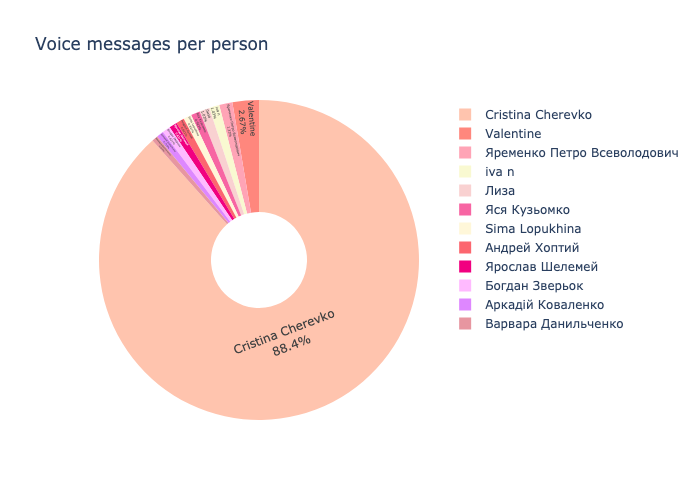

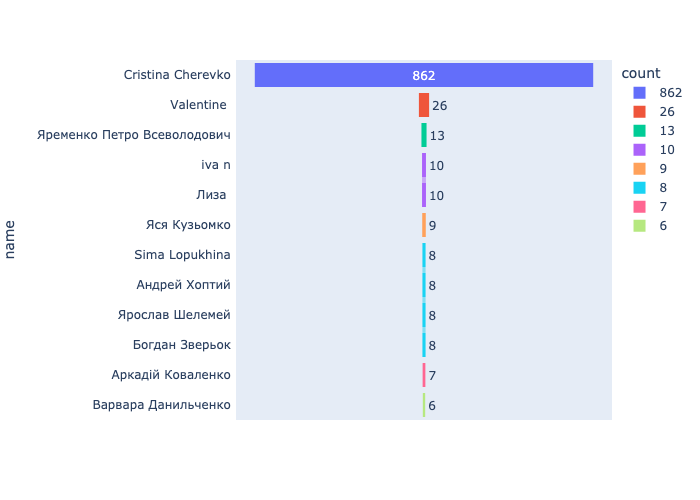

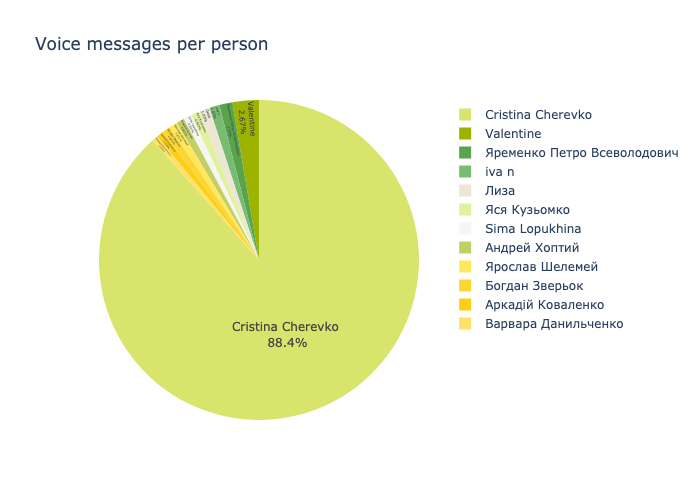

In [261]:
voice_df = df[df['type'] == 'voice'];

voice_df = voice_df[voice_df['from_id'].str.contains('NaN') == False]
voice_df = voice_df[voice_df['to_id'].str.contains('NaN') == False]
voice_df['from_id'] = voice_df['from_id'].str.extract('(\d+)');
voice_df = voice_df.groupby(['from_id'])['from_id'].count().reset_index(name="count")



voice_df['name'] = voice_df['from_id'].apply(lambda x: find_row_by_id(x))
voice_df = voice_df.nlargest(12, ['count'])

colors_peach = ['#FFC4AE', '#FF877D', '#FFA4B6', '#F9F9D1', '#F9D1D1', '#F765A3', '#FFF7D9', '#FC666F', '#F10080', '#FFBAFF', '#DE87FF', '#E796A0']
fig = go.Figure()
fig = px.pie(voice_df, hole=.3, values='count', names='name', title = 'Voice messages per person')
fig.update_traces(textposition='inside', textinfo='percent+label', marker=dict(colors=colors_peach))
fig.show(renderer='png')


fig = px.funnel(voice_df, x='count', y='name', color='count')
fig.show(renderer='png')


colors = ['#D8E46B', '#9DB300', '#57A44D', '#78BC71', '#EDE6D6', '#E2F1A0', '#F5F5F4', 'C2CF67', '#FFE85C', '#FCD733', '#FCCF14', '#FFE169']
fig = px.pie(voice_df, values='count', names='name', title = 'Voice messages per person', color='count')
fig.update_traces(textposition='inside', textinfo='percent+label', marker=dict(colors=colors))
fig.show(renderer='png')

2. Stickers per person (in %)

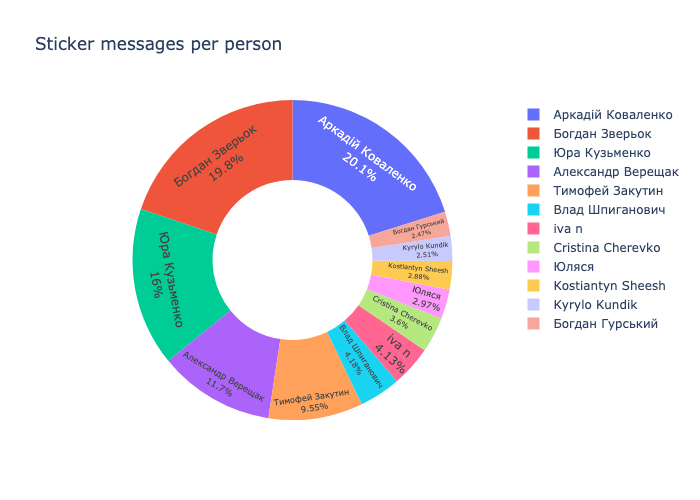

In [262]:
sticker_df = df[df['type'] == 'sticker'];
sticker_df = sticker_df.groupby(['from_id'])["type"].count().reset_index(name="count")
sticker_df['from_id'] = sticker_df['from_id'].str.extract('(\d+)');

sticker_df['name'] = sticker_df['from_id'].apply(lambda x: find_row_by_id(x))
sticker_df = sticker_df.nlargest(12, ['count'])
fig = px.pie(sticker_df, hole=.5, values='count', names='name', title = 'Sticker messages per person')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer='png')

3. Emoji frequency in all chats in telegram

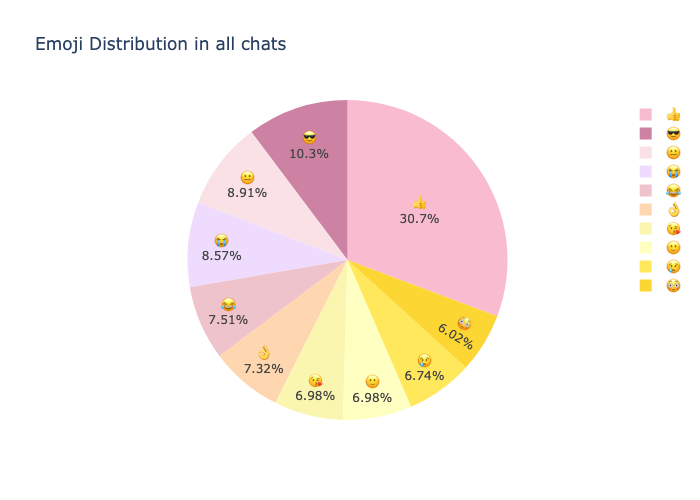

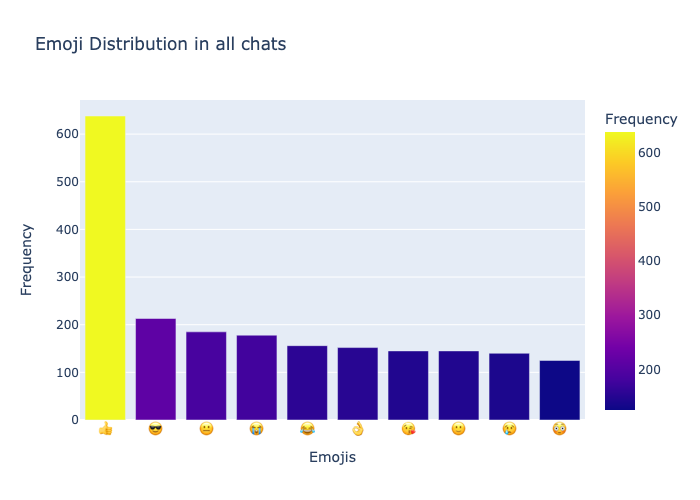

In [263]:
sticker_df = df[df['type'] == 'sticker'];
sticker_df = sticker_df.groupby(['message'])["message"].count().reset_index(name="count")
sticker_df = sticker_df.nlargest(10, ['count'])
emoji_df = pd.DataFrame(sticker_df, columns=['message', 'count'])
emoji_df.replace(to_replace='None', value=numpy.nan).dropna()
emoji_df.replace(to_replace=0, value=numpy.nan).dropna()

colors = ['#f8bbd0', '#cd82a4', '#f9e1e6', '#eedbfe', '#efc3cb', '#fed7b1', '#FAF6AF', '#FFFFC2', '#FFE85C', '#FCD733']
fig = px.pie(emoji_df, values='count', names='message', title = 'Emoji Distribution in all chats')
fig.update_traces(textposition='inside', textinfo='percent+label', marker =dict(colors=colors))
fig.show(renderer='png')

fig = px.bar(emoji_df, x='message', y='count', labels={"message": "Emojis", "count": "Frequency"},
             hover_data=['message', 'count'], color='count', title='Emoji Distribution in all chats',
             height=500)

fig.show(renderer='png')

4. Top-10 Emojis which I use the most

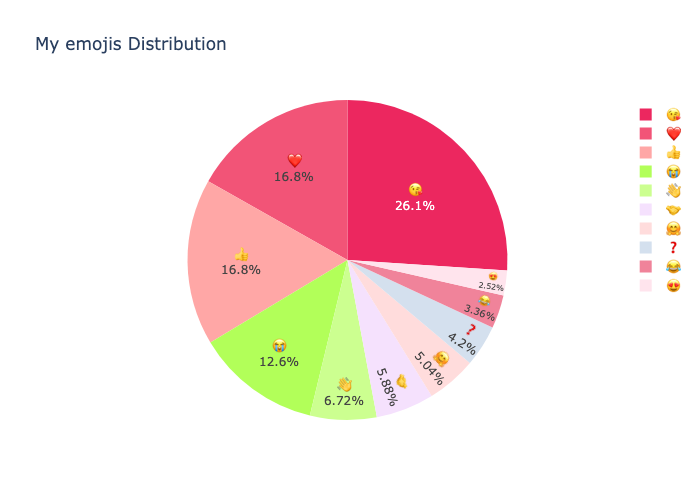

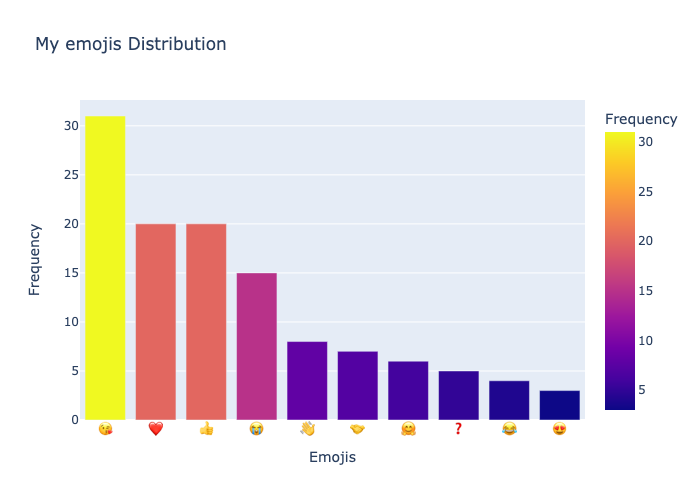

In [264]:
sticker_df = df[df['from_id'].str.contains(my_id, na = False)]
sticker_df = sticker_df[sticker_df['type'] == 'sticker'];
sticker_df = sticker_df.groupby(['message'])["message"].count().reset_index(name="count")
sticker_df = sticker_df.nlargest(10, ['count'])
emoji_df = pd.DataFrame(sticker_df, columns=['message', 'count'])
emoji_df.replace(to_replace='None', value=numpy.nan).dropna()
emoji_df.replace(to_replace=0, value=numpy.nan).dropna()

colors = ['#ec275f', '#f25477', '#ffa7a6', '#b2ff59', '#ccff90', '#F5E1FD', '#ffdcdc', '#d4e0ee', '#f0839a', '#ffe4ed']
fig = px.pie(emoji_df, values='count', names='message', title = 'My emojis Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label', marker =dict(colors=colors))
fig.show(renderer='png')

fig = px.bar(emoji_df, x='message', y='count', labels={"message": "Emojis", "count": "Frequency"},
             hover_data=['message', 'count'], color='count',
             title='My emojis Distribution', height=500)
fig.show(renderer='png')

5. Word cloud for all chats in my telegram

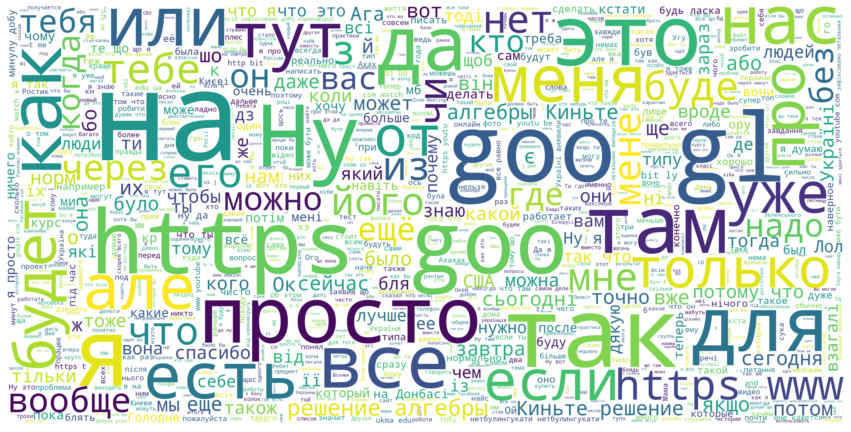

In [265]:
from wordcloud import WordCloud, STOPWORDS
text = df[df['message'].str.contains('NaN') == False]
word_string=" ".join(text['message'])
stopwords = ['в', 'і', 'и', 'та', 'с', 'то', 'но', 'у', 'по', 'як', 'а', 'це', 'до', 'не', 'за']
#stopwords
#stopwords.add(list_of_words)
plt.figure(figsize=(15,15))
wordcloud = WordCloud(background_color="white", stopwords=stopwords, max_words=1000, max_font_size = 450,  width=3000, height=1500)
wordcloud.generate(word_string)
plt.imshow(wordcloud.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')
plt.show()

6. My word cloud (most popular words that I use in my daily chats)

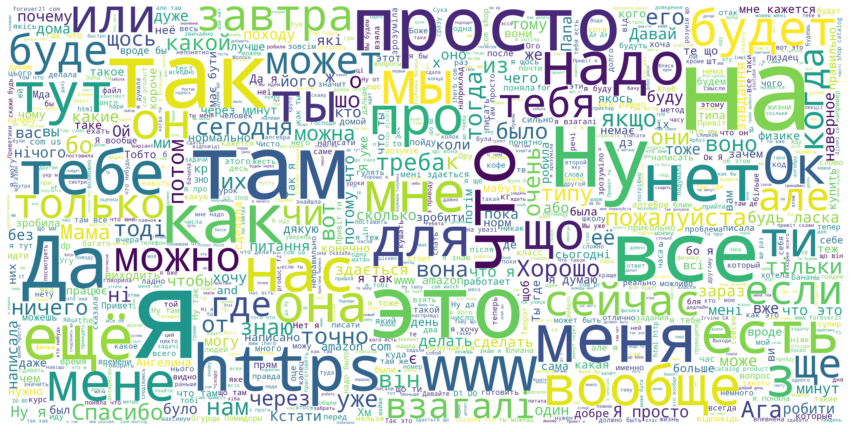

In [266]:
df_me = df[df['from_id'].str.contains(my_id, na = False)]
text = df_me[df_me['message'].str.contains('NaN') == False]
word_string=" ".join(text['message'])
plt.figure(figsize=(15,15))
wordcloud = WordCloud(background_color="white", stopwords=stopwords, max_words=1000, max_font_size = 450,  width=3000, height=1500)
wordcloud.generate(word_string)
plt.imshow(wordcloud.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')
plt.show()

7. Number of messages per day of week. Hypothesis: most inactive days are Saturday and Sunday, because these days people usually spend with their families and friends. Proof - plot demonstates my statement. 


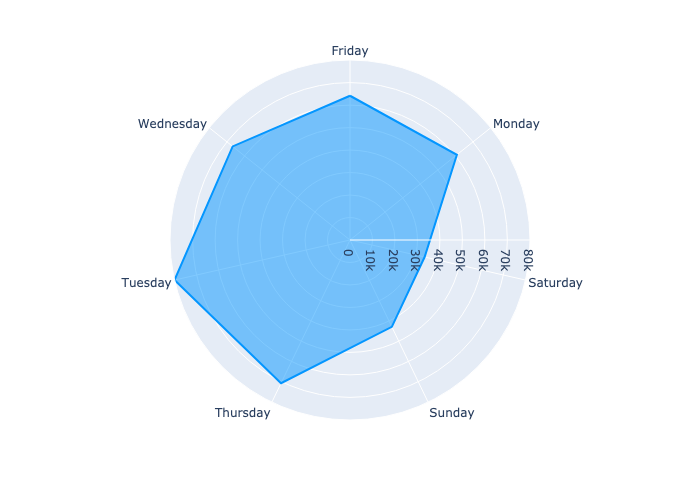

In [267]:
def dayofweek(i):
  week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return week[i];

new_df = pd.DataFrame(df, columns=['message', 'date'])
new_df = new_df.dropna()
day_df=pd.DataFrame(new_df['message'])
new_df["datetime"] = pd.to_datetime(new_df['date'])

day_df['week_day'] = new_df['datetime'].dt.weekday
day_df['week_day'] = day_df["week_day"].apply(dayofweek)
day_df["message_count"] = 1
day = day_df.groupby("week_day").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='message_count', theta='week_day', line_close=True, color_discrete_sequence=['#0496FF'] )
fig.update_traces(fill='toself')
fig.update_layout(polar=dict(radialaxis=dict(visible=True)), showlegend=False)
fig.show(renderer='png')

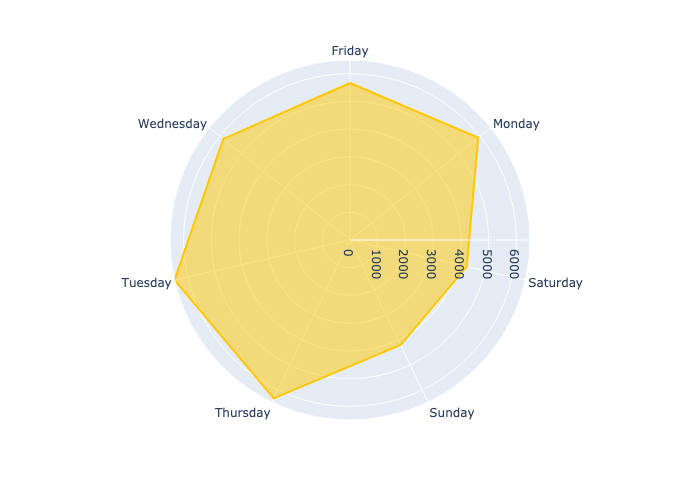

In [268]:
me = df[df['from_id'].str.contains(my_id, na = False)]
my_new_df = pd.DataFrame(me, columns=['message', 'date'])
my_new_df = my_new_df.dropna()
my_day_df = pd.DataFrame(my_new_df['message'])
my_new_df["datetime"] = pd.to_datetime(my_new_df['date'])

my_day_df['week_day'] = my_new_df['datetime'].dt.weekday
my_day_df['week_day'] = my_day_df["week_day"].apply(dayofweek)
my_day_df["message_count"] = 1
day = my_day_df.groupby("week_day").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='message_count', theta='week_day', line_close=True, color_discrete_sequence=['#FFC800'])
fig.update_traces(fill='toself')
fig.update_layout(polar=dict(radialaxis=dict(visible=True)), showlegend=False)
fig.show(renderer='png')

8. Number of words / time. In this question I calculate how "active" was my telegram through time. It is very interesting how my activity was pretty low through 2017 - middle of 2020 years and how it jumped at the end of 2020 - beginning of 2021

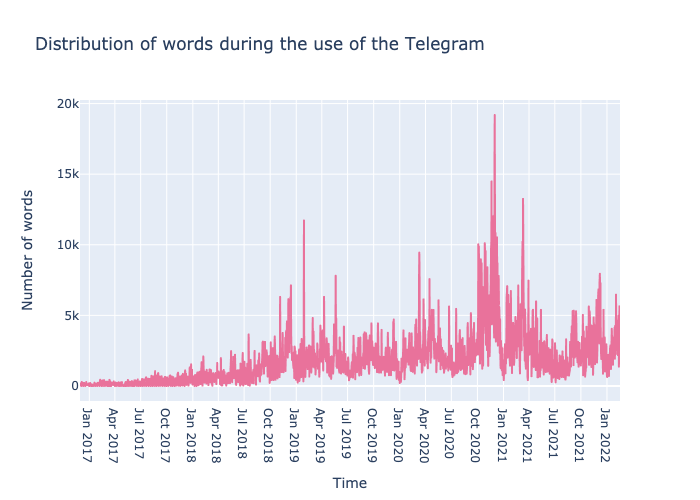

In [269]:
df_time = pd.DataFrame(df, columns=['date', 'message'])
df_time["word_count"] = df["message"].apply(lambda x: get_words_count(x))
df_time = df_time.dropna()
df_time["datetime"] = pd.to_datetime(df_time['date'])
df_time.index = df_time['datetime']
date_df_hello = df_time.resample("D").sum()
date_df_hello.reset_index(inplace=True)
fig = px.line(date_df_hello, x="datetime", y="word_count", color_discrete_sequence=['#E9729B'], 
              labels={"datetime": "Time", "word_count": "Number of words"}, 
              title='Distribution of words during the use of the Telegram')
fig.update_xaxes(nticks=30)
fig.show(renderer='png')

9. Number of words / time. In this question I calculate how "active" I was in chatting through time.

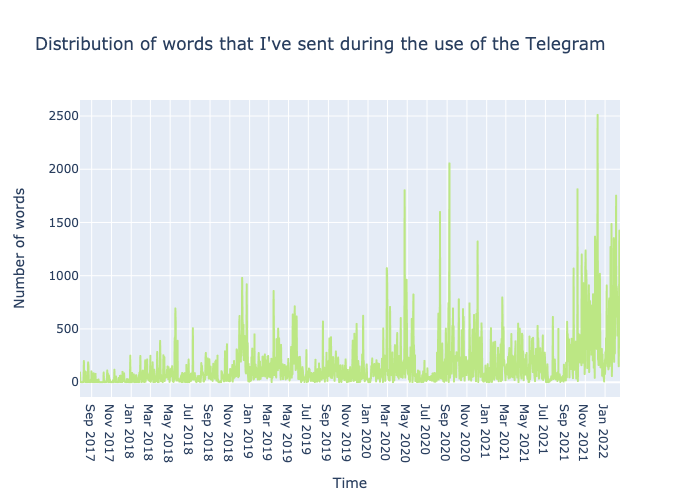

In [270]:
me = df[df['from_id'].str.contains(my_id, na = False)]
df_time = pd.DataFrame(me, columns=['date', 'message'])
df_time["word_count"] = df["message"].apply(lambda x: get_words_count(x))
df_time = df_time.dropna()
df_time["datetime"] = pd.to_datetime(df_time['date'])
df_time.index = df_time['datetime']
date_df_hello = df_time.resample("D").sum()
date_df_hello.reset_index(inplace=True)
fig = px.line(date_df_hello, x="datetime", y="word_count", color_discrete_sequence=['#BCE784'], 
              labels={"datetime": "Time", "word_count": "Number of words"},
              title='Distribution of words that I\'ve sent during the use of the Telegram')
fig.update_xaxes(nticks=30)
fig.show(renderer='png')

10. Distibution of messages by hour. This plot shows most active hours in telegram. There is almost even distribution between 8:00 - 20:00 every day, which is logical, because at this time I receive and send most of my messages.

<AxesSubplot:ylabel='hour'>

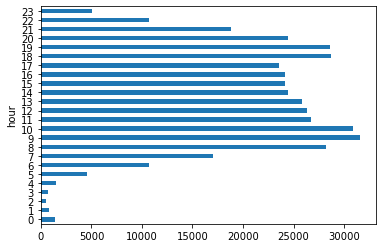

In [271]:
df_time = pd.DataFrame(df, columns=['date', 'message'])
df_time["message_count"] = 1
df_time = df_time.dropna()
df_time["datetime"] = pd.to_datetime(df_time['date'])
df_time.index = df_time['datetime']
df_time["hour"] = df_time.datetime.dt.hour
df_time.groupby("hour")["message_count"].sum().head(24).plot.barh()

11. Distribution of message (words) activity in Примати20х2 through day. Hypotesis - as most people are tend to spleep late at night, this means that activity will be at the lowest point between 1AM - 6AM.  

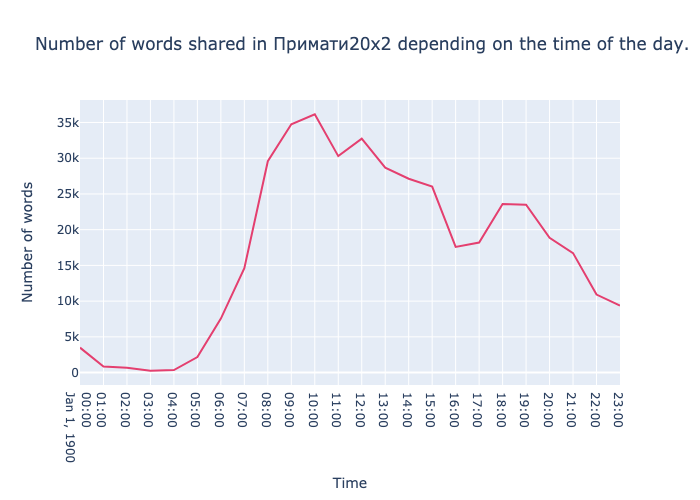

In [272]:
df_temp = df_meta[df_meta['name'] == 'Примати20х2']
group = df_meta.groupby('name', as_index=False).get_group('Примати20х2')
group_id = group.drop_duplicates(subset='dialog_id', keep='first')['dialog_id']
df_group = df.loc[df['dialog_id'].isin(group_id)]

df_time = pd.DataFrame(df_group, columns=['date', 'message'])
df_time["word_count"] = df_group["message"].apply(lambda x: get_words_count(x))
df_time = df_time.dropna()
df_time["datetime"] = pd.to_datetime(df_time['date'])
df_time['hours'] = df_time['datetime'].dt.hour
df_time['hours'] = pd.to_datetime(df_time['hours'], format='%H')
df_time.index = df_time['hours']

hello = df_time.resample('1H').sum()
hello.reset_index(inplace=True)

fig = px.line(hello, x="hours", y="word_count", color_discrete_sequence=['#E43F6F'], 
              labels={"hours": "Time", "word_count": "Number of words"},
              title='Number of words shared in Примати20х2 depending on the time of the day.')
fig.update_xaxes(nticks=30)
fig.show(renderer='png')

12. Count of messages shared through years (by month)

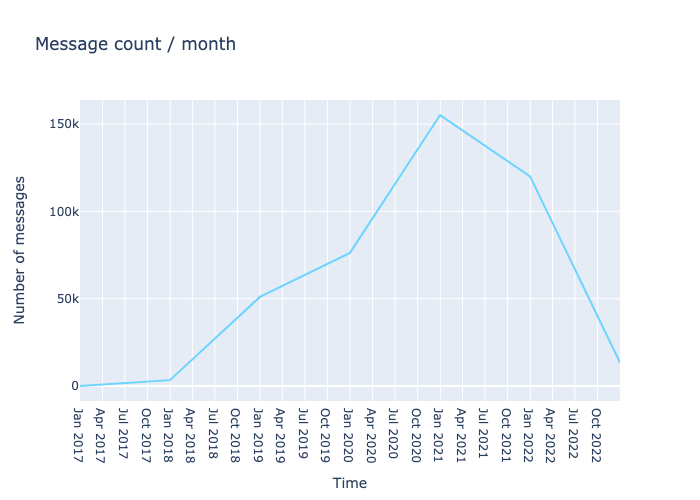

In [297]:
df_time = pd.DataFrame(df, columns=['date', 'message'])

df_time["message_count"] = 1
#df_time["word_count"] = df["message"].apply(lambda x: get_words_count(x))
df_time = df_time.dropna()
df_time["datetime"] = pd.to_datetime(df_time['date'])
df_time['year'] = df_time['datetime'].dt.year
df_time['year'] = pd.to_datetime(df_time['year'], format='%Y')
df_time.index = df_time['year']
date_df_hello = df_time.resample("Y").sum()
date_df_hello.reset_index(inplace=True)
fig = px.line(date_df_hello, x="year", y="message_count", color_discrete_sequence=['#6CD4FF'], 
              labels={"year": "Time", "message_count": "Number of messages"}, title='Message count / month')
fig.update_xaxes(nticks=30)
fig.show(renderer='png')

13. Top-15 people with the biggest average length of messages sent.

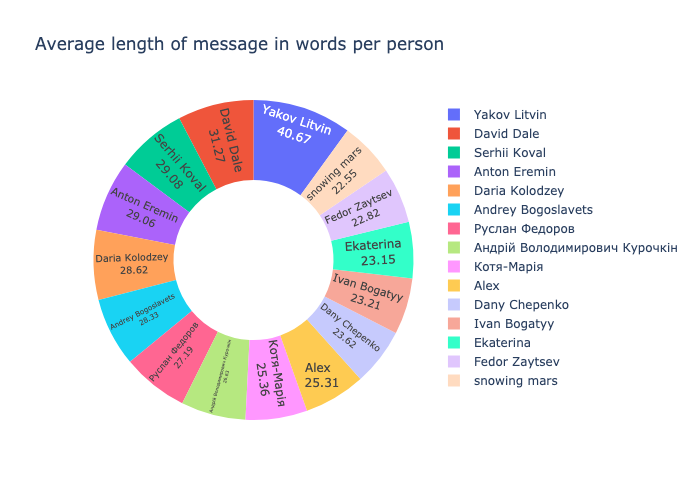

In [274]:
people = df['from_id'].str.extract('(\d+)')
people = people.drop_duplicates()
hello = df
hello.dropna()
hello['word_count'] = hello['message'].apply(lambda x: get_words_count(x))
hello['from_id'] = hello['from_id'].str.extract('(\d+)')
hello = hello[hello['from_id'].str.contains('NaN') == False]
df_apply = pd.DataFrame(hello, columns = ['from_id', 'word_count', 'message'])
df_apply = df_apply.dropna()

df_to_paint = pd.DataFrame(columns = ['from_id', 'word_count', 'number_of_messages', 'average_length'])
for id in people[0]:
    user_df = df_apply[df_apply["from_id"] == id]
    words_per_message = user_df['word_count'].sum()
    if (user_df.shape[0] != 0):
        new_df = pd.DataFrame([(id, words_per_message, user_df.shape[0], round(words_per_message/user_df.shape[0], 2))], columns = ('from_id', 'word_count', 'number_of_messages', 'average_length'))
        df_to_paint = df_to_paint.append(new_df, ignore_index = True)
        df_to_paint.reset_index(drop = True)


res = pd.DataFrame(df_to_paint, columns = ['from_id', 'average_length'])
res['temp'] = 1;
res = res.groupby(['from_id'])['temp'].count().reset_index(name='count')
res['name'] = res['from_id'].apply(lambda x: find_row_by_id(x))
res = res.dropna()
newdf = df_to_paint.merge(res)
newdf.dropna()
newdf = newdf.sort_values('average_length')
newdf = newdf[newdf['number_of_messages'] > 10]
newdf = newdf.nlargest(15, 'average_length')
fig = px.pie(newdf, hole=.5, values='average_length', names='name', title = 'Average length of message in words per person')
fig.update_traces(textposition='inside', textinfo='value+label')
fig.show(renderer='png')

14. Top-15 people with the biggest average length of messages sent in group "Примати20х2".

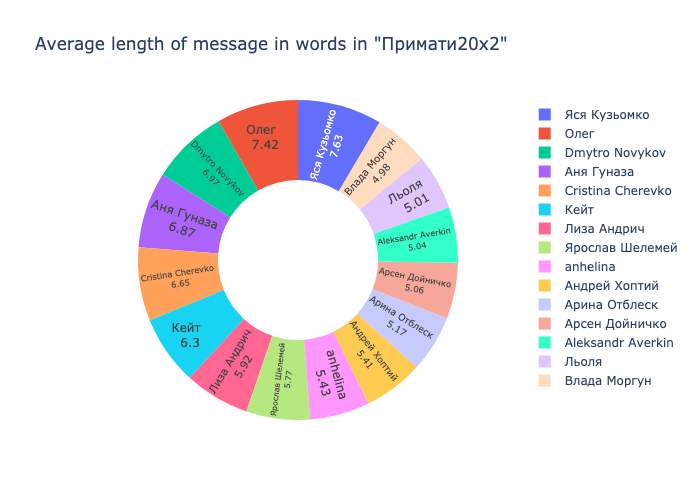

In [275]:
df_temp = df_meta[df_meta['name'] == 'Примати20х2']
df_temp = df_temp.drop_duplicates(subset='dialog_id', keep='first')
group_id = df_temp['dialog_id'].values[0]
primates = df[df['dialog_id'] == group_id]

people = primates['from_id'].str.extract('(\d+)')
people = people.drop_duplicates()
hello = df
hello.dropna()
hello['word_count'] = hello['message'].apply(lambda x: get_words_count(x))
hello['from_id'] = hello['from_id'].str.extract('(\d+)')
hello = hello[hello['from_id'].str.contains('NaN') == False]
df_apply = pd.DataFrame(hello, columns = ['from_id', 'word_count', 'message'])
df_apply = df_apply.dropna()

df_to_paint = pd.DataFrame(columns = ['from_id', 'word_count', 'number_of_messages', 'average_length'])
for id in people[0]:
    user_df = df_apply[df_apply["from_id"] == id]
    words_per_message = user_df['word_count'].sum()
    if (user_df.shape[0] != 0):
        new_df = pd.DataFrame([(id, words_per_message, user_df.shape[0], round(words_per_message/user_df.shape[0], 2))], columns = ('from_id', 'word_count', 'number_of_messages', 'average_length'))
        df_to_paint = df_to_paint.append(new_df, ignore_index = True)
        df_to_paint.reset_index(drop = True)

res = pd.DataFrame(df_to_paint, columns = ['from_id', 'average_length'])
res['temp'] = 1;
res = res.groupby(['from_id'])['temp'].count().reset_index(name='count')
res['name'] = res['from_id'].apply(lambda x: find_row_by_id(x))
res = res.dropna()
newdf = df_to_paint.merge(res)

newdf.dropna()
newdf = newdf.sort_values('average_length')
newdf = newdf[newdf['number_of_messages'] != 1]

newdf = newdf.nlargest(15, 'average_length')
fig = px.pie(newdf, hole=.5, values='average_length', names='name', title = 'Average length of message in words in \"Примати20х2\"')
fig.update_traces(textposition='inside', textinfo='value+label')
fig.show(renderer='png')

15. Gender distribution across all my chats

/var/folders/4f/qyndqk911c14h4_mhwlm61hr0000gp/T/ipykernel_21761/3572426059.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



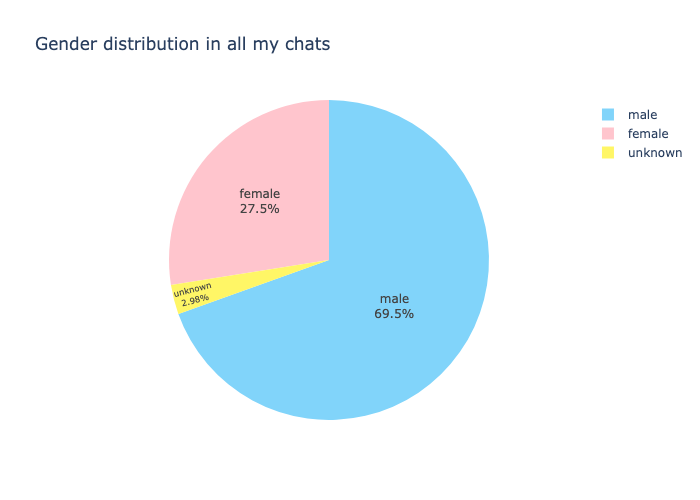

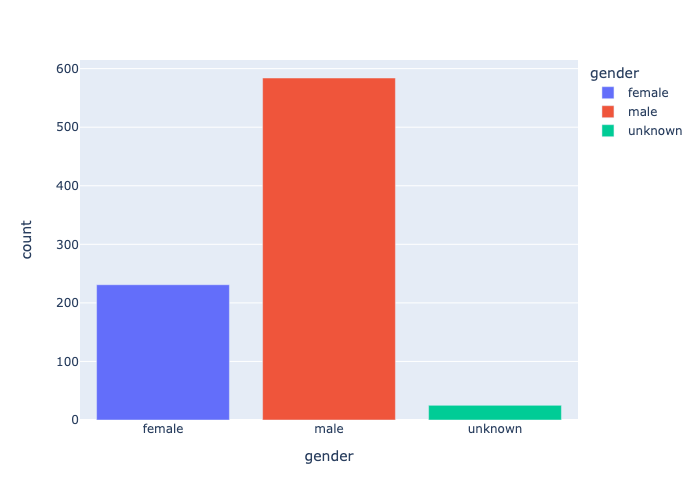

In [276]:
from config import gender

def find_gender(string):
    if ~(string).isdecimal():
        count_female = 0;
        count_male = 0
        words = string.replace('_', ' ').replace(',', ' ').replace('.', ' ').replace('\(', ' ').replace('+', ' ').replace('\)', ' ').split()
        for word in words:
            for fem_name in gender['female_names']:
                if ((word == fem_name)):
                    return 'female';
            for m_name in gender['male_names']:
                if ((word == m_name)):
                    return 'male';
            for f_ending in gender['female']:
                if (word.endswith(f_ending)):
                    count_female+=1;
            for m_ending in gender['male']:
                if (word.endswith(m_ending) & (word.lower() != 'успіхів') & (word.lower() != 'сотрудников') & (word.lower() != 'архів') & (word.lower() != 'біткоїнів')):
                    count_male+=1;
        if (count_female > count_male):
            return 'female';
        if (count_female < count_male):
            return 'male';
        return 'unknown'
def find_gender_by_name(x):
    for f_n in gender['f_names']:
        if ((f_n) in str(x).lower()):
            return 'female';
    for m_n in gender['m_names']:
        if ((m_n) in str(x).lower()):
            return 'male';
    return 'unknown';

gender_df = pd.DataFrame(df, columns = ['from_id', 'message', 'type']);
gender_df = gender_df[gender_df['type'] == 'text'].reset_index(drop = True)

gender_df = gender_df[gender_df['from_id'].str.contains('NaN') == False]
gender_df = gender_df[gender_df['message'].str.contains('NaN') == False]
gender_df['from_id'] = gender_df['from_id'].str.extract('(\d+)');
gender_df = gender_df.dropna()
gender_df['message'] = gender_df.groupby('from_id')['message'].transform(lambda x: ' '.join(x))

gender_df = gender_df.drop_duplicates(subset='from_id', keep='first')

gender_df['name'] = gender_df['from_id'].apply(lambda x: find_row_by_id_u(x))

gender_df['gender'] = gender_df['name'].apply(lambda x: find_gender_by_name(x))

unknown_gender = gender_df[gender_df['gender'] == 'unknown']
unknown_gender['gender'] = unknown_gender['message'].apply(lambda x: find_gender(x))

gender_df = gender_df.append(unknown_gender)


gender_df = gender_df.drop_duplicates(subset=['from_id', 'name'], keep = 'last')
gender_df = gender_df.dropna()
count = gender_df.groupby('gender')['gender'].count().reset_index(name='count')


fig = go.Figure()
fig = px.pie(count, values='count', names='gender', title = 'Gender distribution in all my chats', color=['female', 'male', 'unknown'],
             color_discrete_map={'female':'rgb(255, 197, 205)',
                                 'male':'rgb(129, 212, 250)',
                                 'unknown':'rgb(255, 246, 102)'})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer='png')


fig = px.bar(count, x="gender", y="count", color='gender')
fig.show(renderer='png')




16. Gender distribution in group "Примати20х2"

/var/folders/4f/qyndqk911c14h4_mhwlm61hr0000gp/T/ipykernel_21761/3320149448.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



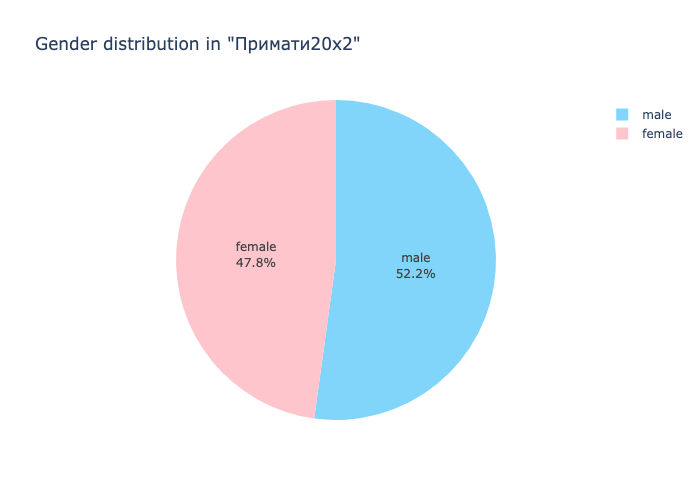

In [277]:
df_temp = df_meta[df_meta['name'] == 'Примати20х2']
df_temp = df_temp.drop_duplicates(subset='dialog_id', keep='first')
group_id = df_temp['dialog_id'].values[0]
primates = df[df['dialog_id'] == group_id]
gender_df = pd.DataFrame(primates, columns = ['from_id', 'message', 'type']);
gender_df = gender_df[gender_df['type'] == 'text'].reset_index(drop = True)

gender_df = gender_df[gender_df['from_id'].str.contains('NaN') == False].reset_index(drop = True)
gender_df = gender_df[gender_df['message'].str.contains('NaN') == False].reset_index(drop = True)
gender_df['from_id'] = gender_df['from_id'].str.extract('(\d+)');
gender_df = gender_df.dropna()
gender_df['message'] = gender_df.groupby('from_id')['message'].transform(lambda x: ' '.join(x)).reset_index(drop = True)

gender_df = gender_df.drop_duplicates(subset='from_id', keep='first')

gender_df['name'] = gender_df['from_id'].apply(lambda x: find_row_by_id_u(x))

gender_df['gender'] = gender_df['name'].apply(lambda x: find_gender_by_name(x))

unknown_gender = gender_df[gender_df['gender'] == 'unknown']
unknown_gender['gender'] = unknown_gender['message'].apply(lambda x: find_gender(x))

gender_df = gender_df.append(unknown_gender)


gender_df = gender_df.drop_duplicates(subset=['from_id', 'name'], keep = 'last')
gender_df = gender_df.dropna()

count = gender_df.groupby('gender')['gender'].count().reset_index(name='count')


fig = go.Figure()
fig = px.pie(count, values='count', names='gender', title = 'Gender distribution in \"Примати20х2\"', color=['female', 'male'],
             color_discrete_map={'female':'rgb(255, 197, 205)',
                                 'male':'rgb(129, 212, 250)'})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer='png')



/var/folders/4f/qyndqk911c14h4_mhwlm61hr0000gp/T/ipykernel_21761/365142501.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4f/qyndqk911c14h4_mhwlm61hr0000gp/T/ipykernel_21761/365142501.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



<AxesSubplot:xlabel='date'>

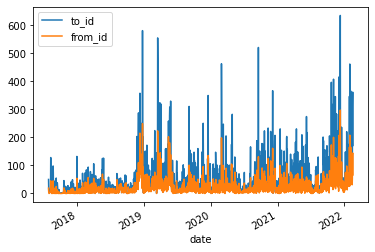

In [278]:
from datetime import datetime
df_temp = df[df["from_id"].str.contains(my_id, na=False) | df["to_id"].str.contains(my_id, na = False)]
df_temp['date'] = (df_temp['date']).apply(lambda x: (datetime.strptime(x[0:10], "%Y-%m-%d"))) 
result = pd.DataFrame(df_temp, columns=['date', 'to_id', 'from_id'])
result = result.groupby(['date'])['to_id', 'from_id'].count()
result[['to_id','from_id']].plot()

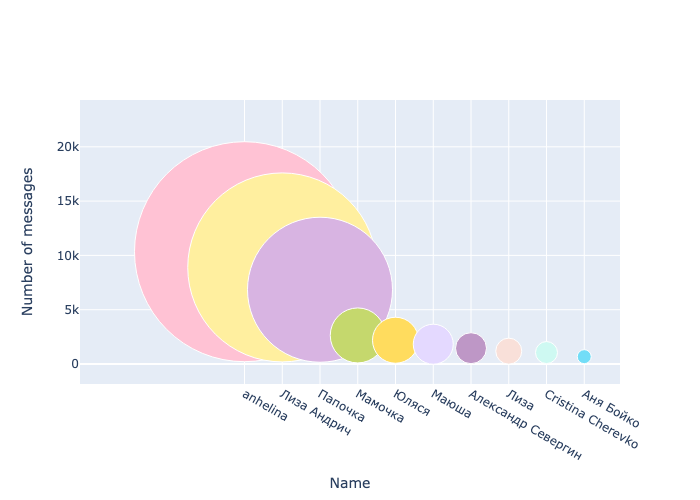

In [298]:
df_received = df[df["to_id"].str.contains(my_id,na=True)]
df_received = df_received.groupby(['dialog_id'])['message'].count().reset_index(name="count")
df_received = df_received.nlargest(10, ['count'])
df_received = df_received.merge(df_meta, left_on=['dialog_id'], right_on=['dialog_id'], how = 'inner')
df_received[['name', 'count']]

df_people = pd.DataFrame(df_received, columns=['name', 'count'])
fig = go.Figure(data=[go.Scatter(
    x=df_people['name'], y=df_people['count'], mode='markers',
    marker=dict(color=['#ffc2d4', '#ffef9f', '#D8B4E2','#C5D86D', '#FFDC5E', '#E4D9FF', '#BE97C6', '#F9E0D9', '#CEF9F2', '#72DDF7'],
        opacity=1,
        size=[220, 189, 145, 55, 46, 40, 31, 26, 22, 14],
    ))
])

fig.update_layout(xaxis_title="Name", yaxis_title="Number of messages")

fig.show(renderer='png')